In [1]:
%matplotlib inline

In [2]:
from thetis import *
from firedrake_adjoint import *

In [3]:
import adolc
import matplotlib.pyplot as plt
import numpy as np

In [4]:
from adapt_utils.case_studies.tohoku.options.okada_options import TohokuOkadaBasisOptions
from adapt_utils.optimisation import taylor_test
from adapt_utils.unsteady.solver import AdaptiveProblem
from adapt_utils.unsteady.solver_adjoint import AdaptiveDiscreteAdjointProblem
from adapt_utils.unsteady.swe.tsunami.conversion import lonlat_to_utm

In [5]:
lonlat_corners = [(138, 32), (148, 42), (138, 42)]
utm_corners = [lonlat_to_utm(*corner, 54) for corner in lonlat_corners]
xlim = [utm_corners[0][0], utm_corners[1][0]]
ylim = [utm_corners[0][1], utm_corners[2][1]]

# Taylor test for the gradient of timeseries misfit w.r.t. Okada parameters

In the previous notebook we computed the gradient using a propagation through the forward mode of AD for the Okada model.
Here we propagate unity through the reverse mode of AD for both models and perform a Taylor test.

### Initialisation

Set parameters and create a `TohokuOkadaBasisOptions` object to hold them

In [6]:
kwargs = {
    
    # Tsunami propagation model
    'level': 0,
    'synthetic': True,
    'plot_pvd': False,
    'save_timeseries': True,
    'family': 'dg-cg',
    'stabilisation': None,
    
    # Okada model
    'okada_grid_lon_min': 140,
    'okada_grid_lon_max': 145,
    'okada_grid_lat_min': 35,
    'okada_grid_lat_max': 41,
    
    'debug': False,
}
nonlinear = False
print_progress = False

In [7]:
# active_controls = ('slip', 'rake', 'strike', 'dip')
active_controls = ('slip', 'rake')

In [8]:
op_data = TohokuOkadaBasisOptions(**kwargs)
op_data.active_controls = active_controls

### Get timeseries data

We use a 'synthetic' approach whereby 'the truth' is given by timeseries extracted from a model run with some Okada parameters.

In [9]:
with stop_annotating():
    swp = AdaptiveProblem(op_data, nonlinear=nonlinear, print_progress=print_progress)
    swp.solve_forward()  # NOTE: pyadolc annotation is also off
    for gauge in op_data.gauges:
        op_data.gauges[gauge]["data"] = op_data.gauges[gauge]["timeseries"]

Perturb the control parameters with some Normal random noise so that the source is different from that used to generate the gauge timeseries data.

In [10]:
kwargs['control_parameters'] = op_data.control_parameters
mu = 0
sigma = 5
for control in op_data.active_controls:
    size = np.shape(op_data.control_parameters[control])
    kwargs['control_parameters'][control] += np.random.normal(loc=mu, scale=sigma, size=size)

In [11]:
op_pert = TohokuOkadaBasisOptions(**kwargs)
op_pert.active_controls = active_controls
for gauge in op_pert.gauges:
    op_pert.gauges[gauge]["data"] = op_data.gauges[gauge]["data"]

### Annotate the source model

When setting the free surface initial condition using the Okada model, we tell `pyadolc` to annotate its tape.

In [12]:
tape_tag = 0
swp = AdaptiveDiscreteAdjointProblem(op_pert, nonlinear=nonlinear, print_progress=print_progress)
swp.set_initial_condition(annotate_source=True, tag=tape_tag, separate_faults=False)

In [13]:
adolc.tapestats(tape_tag)

{'NUM_INDEPENDENTS': 380,
 'NUM_DEPENDENTS': 752,
 'NUM_MAX_LIVES': 262144,
 'TAY_STACK_SIZE': 0,
 'OP_BUFFER_SIZE': 50000000,
 'NUM_OPERATIONS': 575687,
 'OP_FILE_ACCESS': 0,
 'NUM_LOCATIONS': 1435288,
 'LOC_FILE_ACCESS': 0,
 'NUM_VALUES': 286900,
 'VAL_FILE_ACCESS': 0,
 'LOC_BUFFER_SIZE': 50000000,
 'VAL_BUFFER_SIZE': 50000000,
 'TAY_BUFFER_SIZE': 50000000}

### Annotate the tsunami model

Now `pyadjoint` annotates its tape.

In [14]:
init_pert = swp.fwd_solutions[0].copy(deepcopy=True)
source_control = Control(swp.fwd_solutions[0])
swp.setup_solver_forward_step(0)
swp.solve_forward_step(0)
J_pert = op_pert.J
print("QoI: {:.4e}".format(J_pert))

QoI: 1.6274e+05


In [15]:
m_init = op_pert.input_vector
controls_pert = op_pert.control_parameters.copy()

### Reduced functional

Create a `pyadjoint` `ReducedFunctional`.

In [16]:
Jhat = ReducedFunctional(swp.op.J, source_control)

In [17]:
stop_annotating();

In [18]:
def reduced_functional(m):
    """
    Given a vector of control parameters `m`:
      1. run the Okada model to generate the corresponding dislocation field;
      2. set an initial ocean free surface displacement from the dislocation field;
      3. run the tsunami propagation model by traversing the pyadjoint tape.
      
    :return: the corresponding square timeseries error misfit functional value.
    """
    op = swp.op
    num_subfaults = len(op.subfaults)
    num_active_controls = len(op.active_controls)
    
    if isinstance(m, Function):
        print_output("Setting initial condition directly...")
        swp.fwd_solutions[0].assign(m)
    else:
        print_output("Unrolling PyADOL-C's tape...")
        op.set_initial_condition(swp, unroll_tape=True, separate_faults=False)
        
    # Update the initial condition data stored in the ReducedFunctional object
    init = swp.fwd_solutions[0].copy(deepcopy=True)
    Jhat.controls[0].update(init)
    
    # Check the initial conditions match (debugging)
    if not isinstance(m, Function) and np.allclose(m, m_init):
        msg = "Initial conditions do not match: {:.4e} vs. {:.4e}"
        assert np.isclose(errornorm(init, init_pert), 0.0), msg.format(norm(init), norm(init_pert))
    
    # Extract an array from the initial condition data and pass it to the NumPy reduced functional
    print_output("Unrolling pyadjoint's tape...")
    return Jhat(init)  # FIXME: Why does this call break op.lonlat_mesh?

First, test the reduced functional with a NumPy array as input, which implies that the Okada model is run.

In [19]:
J = reduced_functional(m_init)
print_output("QoI: {:.4e}".format(J))

Unrolling PyADOL-C's tape...
Unrolling pyadjoint's tape...
QoI: 1.6274e+05


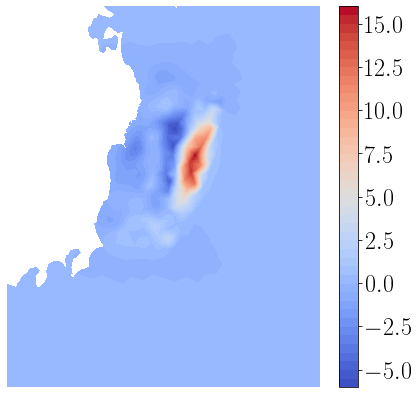

In [20]:
fig, axes = plt.subplots(figsize=(7, 7))
tc = tricontourf(swp.fwd_solutions[0].split()[1], cmap='coolwarm', levels=50, axes=axes)
cbar = fig.colorbar(tc, ax=axes)
# cbar.set_ticks(np.linspace(-1, 7, 5))
axes.set_xlim(xlim)
axes.set_ylim(ylim)
axes.axis(False);

In [21]:
for control in active_controls:
    assert np.allclose(swp.op.control_parameters[control], controls_pert[control])
assert np.isclose(J_pert, J)

Next, test the reduced functional with a `Function` as input, which implies that the Okada model is not run.

In [22]:
J = reduced_functional(init_pert)
print_output("QoI: {:.4e}".format(J))

Setting initial condition directly...
Unrolling pyadjoint's tape...
QoI: 1.6274e+05


In [23]:
for control in active_controls:
    assert np.allclose(swp.op.control_parameters[control], controls_pert[control])
assert np.isclose(J_pert, J)

### Gradient

In [24]:
def gradient(m):
    """
    Given a vector of control parameters `m`, compute the gradient of the reduced functional.
    This is done as follows:
      1. Propagate unity through the *reverse* mode of AD on pyadjoint's tape to endow
         its SolveBlocks with adjoint solutions. Extract the one corresponding to time t = 0.
      2. Propagate `m` through the *forward* mode of AD on pyadolc's tape using an appropriate
         seed matrix. This computes the derivative of the Okada model.
      3. Assemble the gradient by integrating the L2 inner product of adjoint solution at time
         t = 0 with each component of the derivative of the Okada model.
    """
    op = swp.op
    num_subfaults = len(op.subfaults)
    num_active_controls = len(op.active_controls)
    N = len(op.indices)
    
    # Differentiate tsunami propagation
    print_output("Differentiating the tsunami propagation model...")
    dJdq0 = Jhat.derivative()
    if isinstance(m, Function):
        return dJdq0  # FIXME: Not consistent
    
    # Differentiate Okada
    print_output("Differentiating the Okada model...")
    dJdeta0 = interpolate(dJdq0.split()[1], swp.P1[0])
    dJdeta0 = dJdeta0.dat.data[op_pert.indices]
    dJdm = adolc.fos_reverse(tape_tag, dJdeta0)
    return dJdm

### Taylor test

Again, we first perform the Taylor test with a NumPy array as input.

In [25]:
# np.random.seed(23)

In [26]:
taylor_test(reduced_functional, gradient, m_init, verbose=True, ratio_tol=3.95)

========================TAYLOR TEST========================
Unrolling PyADOL-C's tape...
Unrolling pyadjoint's tape...
Differentiating the tsunami propagation model...
Differentiating the Okada model...
h = 1.0000e+00
Unrolling PyADOL-C's tape...
Unrolling pyadjoint's tape...
Taylor remainder = 1.9030e+01
h = 5.0000e-01
Unrolling PyADOL-C's tape...
Unrolling pyadjoint's tape...
Taylor remainder = 9.5151e+00


ConvergenceError: Taylor remainders do not decrease quadratically (ratio 2.0000e+00 < 3.9500e+00)

Then we perform the Taylor test with a `Function` as input.

# [TO DO]

In [ ]:
# import pyadjoint
# h = init_pert.copy(deepcopy=True)
# h.dat.data[0][:] = np.random.normal(loc=0.0, scale=1.0, size=h.dat.data[0].shape)
# h.dat.data[1][:] = np.random.normal(loc=0.0, scale=1.0, size=h.dat.data[1].shape)
# pyadjoint.taylor_test(reduced_functional, init_pert, h, dJdm=gradient(init_pert))